<a href="https://colab.research.google.com/github/msinan52/Python/blob/master/_3B%C4%B0lstm3CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Veri yollarını belirtin
data_dir = "/content/drive/My Drive/80-20"  # Veri klasörünün kök dizini
class_names = ["no","yes"]

Mounted at /content/drive


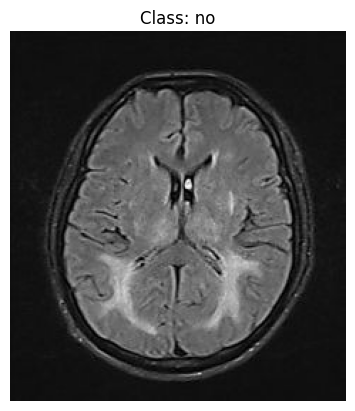

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import random
data_dir = "/content/drive/My Drive/1-a-brain/80-20"  # Veri klasörünün kök dizini
class_names = ["no","yes"]

# Rastgele bir örnek seçme
random_class = random.choice(class_names)
random_image_path = os.path.join(data_dir, random_class, random.choice(os.listdir(os.path.join(data_dir, random_class))))
random_image = cv2.imread(random_image_path)

# Seçilen örneği görselleştirme
plt.imshow(cv2.cvtColor(random_image, cv2.COLOR_BGR2RGB))
plt.title(f'Class: {random_class}')
plt.axis('off')
plt.show()

In [ ]:
import os

data_dir = "/content/drive/My Drive/1-a-brain/80-20"  # Veri klasörünün kök dizini
class_names = ["no","yes"]
# Toplam etiket ve resim sayıları
total_labels = 0
total_images = 0

# Her sınıf için etiket ve resim sayılarını hesapla
for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    class_labels = len(os.listdir(class_dir))
    class_images = len([f for f in os.listdir(class_dir) if f.endswith('.png')])  # .jpg uzantılı dosyaları say

    total_labels += class_labels
    total_images += class_images

    print(f"Sınıf: {class_name}, Etiket Sayısı: {class_labels}, Resim Sayısı: {class_images}")

# Toplam etiket ve resim sayılarını yazdır
print(f"\nToplam Etiket Sayısı: {total_labels}")
print(f"Toplam Resim Sayısı: {total_images}")


Sınıf: no, Etiket Sayısı: 1500, Resim Sayısı: 0
Sınıf: yes, Etiket Sayısı: 1500, Resim Sayısı: 0

Toplam Etiket Sayısı: 3000
Toplam Resim Sayısı: 0


In [ ]:
# Veri ve etiketleri toplama
data = []
labels = []

for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path)  # Resmi yükleme, gerekirse boyut değişikliği yapılabilir
        data.append(cv2.resize(img, (64, 64)))  # Resmi 64x64 boyutuna yeniden boyutlandırma
        labels.append(class_name)

In [ ]:
# NumPy dizilerine dönüştürme
data = np.array(data)
labels = np.array(labels)

In [ ]:
# Veriyi eğitim ve test setlerine ayırma
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
test_labels = label_encoder.transform(test_labels)

# Now, you can use to_categorical
train_labels_onehot = to_categorical(train_labels, num_classes=2)
test_labels_onehot = to_categorical(test_labels, num_classes=2)


In [ ]:
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Conv2D, MaxPooling2D, Flatten, Dense, TimeDistributed

# Modeli oluşturma
bi_cnn_model = Sequential()

# Conv2D katmanları
bi_cnn_model.add(Conv2D(512, (5, 5), activation='relu', input_shape=(64, 64, 3)))
bi_cnn_model.add(Conv2D(512, (5, 5), activation='relu'))
bi_cnn_model.add(Conv2D(512, (5, 5), activation='relu'))
bi_cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

bi_cnn_model.add(TimeDistributed(Flatten()))

bi_cnn_model.add(Bidirectional(LSTM(256, return_sequences=True)))
bi_cnn_model.add(Bidirectional(LSTM(256, return_sequences=True)))
bi_cnn_model.add(Bidirectional(LSTM(256, return_sequences=True)))

bi_cnn_model.add(Flatten())


# Compile the model
bi_cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the summary
bi_cnn_model.summary()


In [ ]:
from keras import metrics
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
# Compile Model
bi_cnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, mode='auto', factor=0.3, min_lr=0.003)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train Model
history = bi_cnn_model.fit(train_data, train_labels_onehot, epochs=50, validation_split=0.2, callbacks=[reduce_lr, early_stopping])


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Get the training and validation metrics
train_accuracy = history.history['accuracy']
train_loss = history.history['loss']


val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']


# Plot the metrics
epochs = range(1, len(train_accuracy) + 1)

plt.figure(figsize=(12, 8))

# Accuracy plot
plt.subplot(2, 2, 1)
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(epochs)  # Set the x-axis ticks explicitly

# Loss plot
plt.subplot(2, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)  # Set the x-axis ticks explicitly


In [ ]:
from keras import metrics
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
# Compile Model
bi_cnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, mode='auto', factor=0.3, min_lr=0.003)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train Model
history = bi_cnn_model.fit(train_data, train_labels_onehot, epochs=50, validation_split=0.1, callbacks=[reduce_lr, early_stopping])


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Get the training and validation metrics
train_accuracy = history.history['accuracy']
train_loss = history.history['loss']


val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']


# Plot the metrics
epochs = range(1, len(train_accuracy) + 1)

plt.figure(figsize=(12, 8))

# Accuracy plot
plt.subplot(2, 2, 1)
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(epochs)  # Set the x-axis ticks explicitly

# Loss plot
plt.subplot(2, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)  # Set the x-axis ticks explicitly


#keras tunner

In [ ]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.7 MB/s eta 0:00:00


In [ ]:
import kerastuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, Conv2D, MaxPooling2D, Flatten, Dense, LSTM, TimeDistributed
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.applications import DenseNet121
from keras.layers import GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Model function definition
def build_model(hp):
    model = Sequential()

    # Conv2D layers
    model.add(Conv2D(hp.Int('filters_1', min_value=32, max_value=512, step=32),
                     (5, 5), activation='relu', input_shape=(64, 64, 3)))
    model.add(Conv2D(hp.Int('filters_2', min_value=32, max_value=512, step=32),
                     (5, 5), activation='relu'))
    model.add(Conv2D(hp.Int('filters_3', min_value=32, max_value=512, step=32),
                     (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # TimeDistributed LSTM layers
    model.add(TimeDistributed(Bidirectional(LSTM(units=hp.Int('units_1', min_value=32, max_value=512, step=32),
                                                return_sequences=True))))
    model.add(TimeDistributed(Bidirectional(LSTM(units=hp.Int('units_2', min_value=32, max_value=512, step=32),
                                                return_sequences=True))))
    model.add(TimeDistributed(Bidirectional(LSTM(units=hp.Int('units_3', min_value=32, max_value=512, step=32),
                                                return_sequences=True))))


    model.add(Flatten())
    model.add(Dense(units=2, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Tuner creation
tuner = kt.BayesianOptimization(build_model,
                                objective='val_accuracy',
                                max_trials=10,  # You can adjust the number of trials
                                directory='my_dir',
                                project_name='helloworld')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, mode='auto', factor=0.3, min_lr=0.003)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Tuner search
tuner.search(train_data, train_labels_onehot, epochs=100, validation_split=0.5, callbacks=[reduce_lr, early_stopping])

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the best model
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(train_data, train_labels_onehot, epochs=100, validation_split=0.5, callbacks=[reduce_lr, early_stopping])


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Get the training and validation metrics
train_accuracy = history.history['accuracy']
train_loss = history.history['loss']


val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']


# Plot the metrics
epochs = range(1, len(train_accuracy) + 1)

plt.figure(figsize=(12, 8))

# Accuracy plot
plt.subplot(2, 2, 1)
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(epochs)  # Set the x-axis ticks explicitly

# Loss plot
plt.subplot(2, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)  # Set the x-axis ticks explicitly


In [ ]:
import kerastuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, Conv2D, MaxPooling2D, Flatten, Dense, LSTM, TimeDistributed
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.applications import DenseNet121
from keras.layers import GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Model function definition
def build_model(hp):
    model = Sequential()

    # Conv2D layers
    model.add(Conv2D(hp.Int('filters_1', min_value=32, max_value=512, step=32),
                     (5, 5), activation='relu', input_shape=(64, 64, 3)))
    model.add(Conv2D(hp.Int('filters_2', min_value=32, max_value=512, step=32),
                     (5, 5), activation='relu'))
    model.add(Conv2D(hp.Int('filters_3', min_value=32, max_value=512, step=32),
                     (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # TimeDistributed LSTM layers
    model.add(TimeDistributed(Bidirectional(LSTM(units=hp.Int('units_1', min_value=32, max_value=512, step=32),
                                                return_sequences=True))))
    model.add(TimeDistributed(Bidirectional(LSTM(units=hp.Int('units_2', min_value=32, max_value=512, step=32),
                                                return_sequences=True))))
    model.add(TimeDistributed(Bidirectional(LSTM(units=hp.Int('units_3', min_value=32, max_value=512, step=32),
                                                return_sequences=True))))

    # Flatten and Dense layers
    model.add(TimeDistributed(Flatten()))
    model.add(Bidirectional(LSTM(units=hp.Int('dense_units', min_value=32, max_value=256, step=32),
                                 return_sequences=True)))
    model.add(Flatten())
    model.add(Dense(units=2, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Tuner creation
tuner = kt.BayesianOptimization(build_model,
                                objective='val_accuracy',
                                max_trials=10,  # You can adjust the number of trials
                                directory='my_dir',
                                project_name='helloworld')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, mode='auto', factor=0.3, min_lr=0.003)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Tuner search
tuner.search(train_data, train_labels_onehot, epochs=100, validation_split=0.1, callbacks=[reduce_lr, early_stopping])

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the best model
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(train_data, train_labels_onehot, epochs=100, validation_split=0.1, callbacks=[reduce_lr, early_stopping])


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Get the training and validation metrics
train_accuracy = history.history['accuracy']
train_loss = history.history['loss']


val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']


# Plot the metrics
epochs = range(1, len(train_accuracy) + 1)

plt.figure(figsize=(12, 8))

# Accuracy plot
plt.subplot(2, 2, 1)
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(epochs)  # Set the x-axis ticks explicitly

# Loss plot
plt.subplot(2, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)  # Set the x-axis ticks explicitly


In [ ]:
# Modeli değerlendirme
accuracy = best_model.evaluate(test_data, test_labels_onehot)[1]
print("Test accuracy:", accuracy)

19/19 [==============================] - 18s 792ms/step - loss: 0.1304 - accuracy: 0.9567
Test accuracy: 0.9566666483879089


In [ ]:
# Modeli değerlendir
evaluation = best_model.evaluate(test_data, test_labels_onehot)
test_accuracy = evaluation[1]
print("Test accuracy:", test_accuracy)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Get the training and validation metrics
train_accuracy = history.history['accuracy']
train_loss = history.history['loss']


val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']


# Plot the metrics
epochs = range(1, len(train_accuracy) + 1)

plt.figure(figsize=(12, 8))

# Accuracy plot
plt.subplot(2, 2, 1)
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(epochs)  # Set the x-axis ticks explicitly

# Loss plot
plt.subplot(2, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)  # Set the x-axis ticks explicitly

19/19 [==============================] - 17s 791ms/step


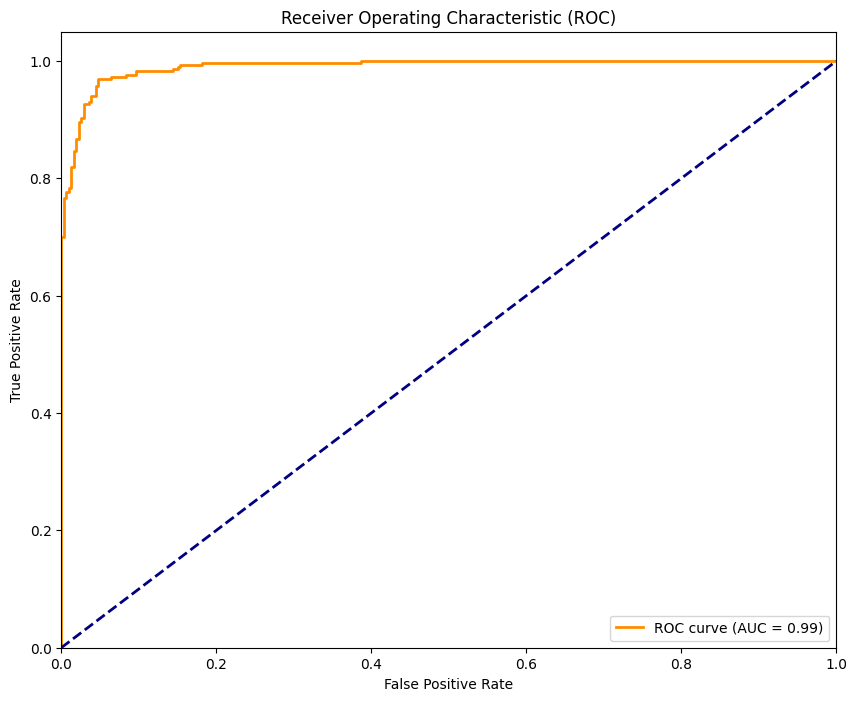

In [ ]:
from sklearn.metrics import roc_curve, auc

# Tahminleri yap
predicted_probabilities = best_model.predict(test_data)

# Gerçek etiketleri al
true_labels_positive = test_labels_onehot[:, 1]   # İkinci sütun (1) pozitif sınıfı temsil eder

# ROC eğrisini ve AUC değerini hesapla
fpr, tpr, thresholds = roc_curve(true_labels_positive, predicted_probabilities[:, 1])  # predicted_probabilities'ın ikinci sütunu pozitif sınıfı temsil eder
roc_auc = auc(fpr, tpr)

# ROC eğrisini çizdir
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()